In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
import numpy as np
import os
import joblib
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical



from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam



**split the features data into train, test and validation such that only train data contains augmented segment data, while validation and test contains only original audio segment data**

In [ ]:

# Define the path to the directory containing the spectrogram images
spectrogram_dir = "/content/drive/MyDrive/music genre classification/Data/3sec_with_3_augmented_spectrogram_images"


# Model input shape
input_shape = (64, 64, 3)

# Dictionaries to store data
original_data = {}  # Stores only original spectrograms
augmented_data = defaultdict(list)  # Stores augmented samples
filename_dict = defaultdict(list)  # Track filenames

# Process spectrogram images
for genre_folder in os.listdir(spectrogram_dir):
    genre_dir = os.path.join(spectrogram_dir, genre_folder)
    if os.path.isdir(genre_dir):
        print(f"Processing genre: {genre_folder}")
        for filename in os.listdir(genre_dir):
            if filename.endswith('.png'):
                filepath = os.path.join(genre_dir, filename)
                spectrogram = tf.keras.preprocessing.image.load_img(filepath, target_size=(input_shape[0], input_shape[1]))
                spectrogram = tf.keras.preprocessing.image.img_to_array(spectrogram)
                spectrogram /= 255.0  # Normalize pixel values

                # Extract components from filename
                base_name = filename[:-4]  # Remove '.png'
                parts = base_name.split('.')

                if len(parts) == 3:
                    # Original sample (e.g., 'rock.00001.0.png')
                    genre, sample_id, part_id = parts
                    key = f"{genre}.{sample_id}.{part_id}"  # Unique key for original sample
                    original_data[key] = (spectrogram, genre_folder)
                    filename_dict[key].append(filename)  # Track filenames

                elif len(parts) == 4:
                    # Augmented sample (e.g., 'rock.00001.0.0.png')
                    genre, sample_id, part_id, aug_id = parts
                    key = f"{genre}.{sample_id}.{part_id}"  # Link to corresponding original
                    augmented_data[key].append((spectrogram, genre_folder))
                    filename_dict[key].append(filename)  # Track filenames


# Sort original_data by keys for consistent splitting
sorted_original_data = dict(sorted(original_data.items()))

# Get the list of original spectrogram keys (grouped by part-level) - now sorted
original_keys = list(sorted_original_data.keys())

# Ensure test/val split includes ONLY original spectrograms
train_keys, temp_keys = train_test_split(
    original_keys, test_size=0.35, random_state=42, stratify=[key.split('.')[0] for key in original_keys]
)
val_keys, test_keys = train_test_split(
    temp_keys, test_size=0.5, random_state=42, stratify=[key.split('.')[0] for key in temp_keys]
)

# Initialize train, validation, and test sets
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []
test_filenames = []  # Store test filenames for verification

# Validation & Test Sets: Only Add Original Spectrograms
for key in val_keys:
    spectrogram, label = sorted_original_data[key]  # Access from sorted data
    X_val.append(spectrogram)
    y_val.append(label)
    test_filenames.append(f"{key}.png")  # Directly construct original filename

for key in test_keys:
    spectrogram, label = sorted_original_data[key]  # Access from sorted data
    X_test.append(spectrogram)
    y_test.append(label)
    test_filenames.append(f"{key}.png")  # Directly construct original filename

# Train Set: Add Both Original & Augmented Samples
for key in train_keys:
    spectrogram, label = sorted_original_data[key]  # Access from sorted data
    X_train.append(spectrogram)
    y_train.append(label)

    # Add Corresponding Augmented Samples to Training Set
    if key in augmented_data:
        for aug_spectrogram, aug_label in augmented_data[key]:
            X_train.append(aug_spectrogram)
            y_train.append(aug_label)

# Convert to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Print sample counts
print(f"\nTrain samples: {len(y_train)}, Validation samples: {len(y_val)}, Test samples: {len(y_test)}\n")

# Print label distribution in a readable format
def print_label_distribution(dataset_name, labels):
    label_counts = Counter(labels)
    print(f"Label distribution in {dataset_name} Data:")
    for label, count in sorted(label_counts.items()):
        print(f"{label}: {count} samples")
    print()  # Blank line for readability

print_label_distribution("Train", y_train)
print_label_distribution("Validation", y_val)
print_label_distribution("Test", y_test)

# Print test filenames (only original features)
print("Filenames in Test Data (should be only original features):")
print("\n".join(sorted(test_filenames)[:10]))  # Print first 10 filenames for readability


# Save before transformations
np.save('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/X_train_spectrogram_raw.npy', X_train)
np.save('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/X_val_spectrogram_raw.npy', X_val)
np.save('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/X_test_spectrogram_raw.npy', X_test)
np.save('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/y_train_spectrogram_raw.npy', np.array(y_train, dtype=object))
np.save('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/y_val_spectrogram_raw.npy', np.array(y_val, dtype=object))
np.save('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/y_test_spectrogram_raw.npy', np.array(y_test, dtype=object))

Processing genre: reggae
Processing genre: jazz
Processing genre: pop
Processing genre: metal
Processing genre: blues
Processing genre: rock
Processing genre: country
Processing genre: classical
Processing genre: disco
Processing genre: hiphop

Train samples: 25976, Validation samples: 1748, Test samples: 1749

Label distribution in Train Data:
blues: 2600 samples
classical: 2596 samples
country: 2592 samples
disco: 2596 samples
hiphop: 2596 samples
jazz: 2600 samples
metal: 2600 samples
pop: 2600 samples
reggae: 2600 samples
rock: 2596 samples

Label distribution in Validation Data:
blues: 175 samples
classical: 174 samples
country: 175 samples
disco: 175 samples
hiphop: 174 samples
jazz: 175 samples
metal: 175 samples
pop: 175 samples
reggae: 175 samples
rock: 175 samples

Label distribution in Test Data:
blues: 175 samples
classical: 175 samples
country: 174 samples
disco: 175 samples
hiphop: 175 samples
jazz: 175 samples
metal: 175 samples
pop: 175 samples
reggae: 175 samples
rock:

In [ ]:
# Option to load data
LOAD_FROM_FILES = True  # Set to True to load saved data instead of recomputing

if LOAD_FROM_FILES:
    X_train = np.load('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/X_train_spectrogram_raw.npy')
    X_val = np.load('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/X_val_spectrogram_raw.npy')
    X_test = np.load('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/X_test_spectrogram_raw.npy')
    y_train = np.load('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/y_train_spectrogram_raw.npy', allow_pickle=True)
    y_val = np.load('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/y_val_spectrogram_raw.npy', allow_pickle=True)
    y_test = np.load('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/y_test_spectrogram_raw.npy', allow_pickle=True)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
joblib.dump(label_encoder, 'label_encoder.pkl')

# One-hot encoding
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes=num_classes)
y_val = to_categorical(y_val_encoded, num_classes=num_classes)
y_test = to_categorical(y_test_encoded, num_classes=num_classes)


In [ ]:
# print shape of data
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (25976, 64, 64, 3)
X_val shape: (1748, 64, 64, 3)
X_test shape: (1749, 64, 64, 3)


In [ ]:
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def model_evaluation_report(model):

  # Evaluate the model on the test data
  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=1)

  # Inverse transform encoded labels to original labels
  y_test_original = label_encoder.inverse_transform(y_test.argmax(axis=1))
  y_pred_original = label_encoder.inverse_transform(y_pred_classes)

  # Print classification report
  print(classification_report(y_test_original, y_pred_original))

  # Plot the confusion matrix
  conf_matrix = confusion_matrix(y_test_original, y_pred_original)
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, cmap='Blues',  annot=True)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=90)
  plt.yticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_)
  plt.show()



CNN model

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))


model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))


model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))


# Define a ModelCheckpoint callback to save the entire model (including architecture and weights)
model_checkpoint = ModelCheckpoint('CNN_spectrogram_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Train the model with early stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=21, restore_best_weights=True  # Stop if val_loss doesn't improve for 5 epochs
)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_val, y_val), callbacks=[model_checkpoint, early_stopping])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1439 - loss: 2.2389
Epoch 1: val_accuracy improved from -inf to 0.33524, saving model to CNN_spectrogram_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.1442 - loss: 2.2382 - val_accuracy: 0.3352 - val_loss: 1.7833
Epoch 2/250
201/203 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3583 - loss: 1.7387
Epoch 2: val_accuracy improved from 0.33524 to 0.50229, saving model to CNN_spectrogram_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.3586 - loss: 1.7377 - val_accuracy: 0.5023 - val_loss: 1.3867
Epoch 3/250
202/203 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4401 - loss: 1.5179
Epoch 3: val_accuracy improved from 0.50229 to 0.57838, saving model to CNN_spectrogram_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4403 - loss: 1.5176 - val_accuracy: 0.5784 - val_loss: 1.2024
Epoch 4/250
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy:

In [ ]:
# Load the best model
from tensorflow.keras.models import load_model
model = load_model('CNN_spectrogram_model.keras')

# Evaluate the model's accuracy on train and test sets
train_acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1))
validate_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(model.predict(X_val), axis=1))
test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

# Print the accuracy scores
print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {validate_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

812/812 ━━━━━━━━━━━━━━━━━━━━ 103s 125ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step
Train Accuracy: 96.99%
Validation Accuracy: 90.22%
Test Accuracy: 90.57%


55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step
              precision    recall  f1-score   support

       blues       0.91      0.94      0.92       175
   classical       0.89      0.99      0.94       175
     country       0.85      0.90      0.87       174
       disco       0.94      0.94      0.94       175
      hiphop       0.95      0.89      0.91       175
        jazz       0.94      0.82      0.87       175
       metal       0.94      0.94      0.94       175
         pop       0.91      0.86      0.88       175
      reggae       0.92      0.94      0.93       175
        rock       0.83      0.85      0.84       175

    accuracy                           0.91      1749
   macro avg       0.91      0.91      0.91      1749
weighted avg       0.91      0.91      0.91      1749



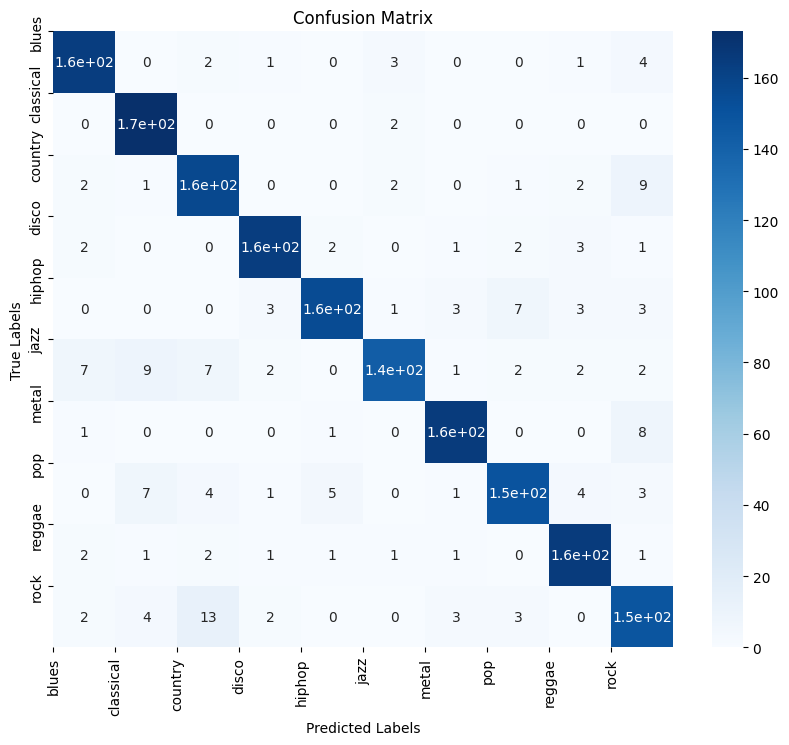

In [ ]:
model_evaluation_report(model)

## GRU models

In [ ]:
# Build the CRNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

# Add recurrent layers (GRU)
conv_output_shape = model.output_shape[1:]
model.add(layers.Reshape((conv_output_shape[1], conv_output_shape[0]*conv_output_shape[2])))


model.add(layers.GRU(32, return_sequences=True))
model.add(layers.GRU(32))

model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Define a ModelCheckpoint callback to save the entire model (including architecture and weights)
model_checkpoint = ModelCheckpoint('GRU_spectrogram_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=200, batch_size=128, validation_data=(X_val, y_val), callbacks=[model_checkpoint])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1237 - loss: 2.2757
Epoch 1: val_accuracy improved from -inf to 0.24085, saving model to GRU_spectrogram_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.1238 - loss: 2.2754 - val_accuracy: 0.2408 - val_loss: 2.0159
Epoch 2/200
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2858 - loss: 1.9148
Epoch 2: val_accuracy improved from 0.24085 to 0.40789, saving model to GRU_spectrogram_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.2860 - loss: 1.9143 - val_accuracy: 0.4079 - val_loss: 1.5484
Epoch 3/200
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3842 - loss: 1.6300
Epoch 3: val_accuracy improved from 0.40789 to 0.48169, saving model to GRU_spectrogram_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3843 - loss: 1.6298 - val_accuracy: 0.4817 - val_loss: 1.4061
Epoch 4/200
202/203 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy:

In [ ]:
from tensorflow.keras.models import load_model
# Load the best model
model = load_model('GRU_spectrogram_model.keras')

# Evaluate the model's accuracy on train and test sets
train_acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1))
validate_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(model.predict(X_val), axis=1))
test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

# Print the accuracy scores
print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {validate_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

812/812 ━━━━━━━━━━━━━━━━━━━━ 56s 68ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
Train Accuracy: 96.60%
Validation Accuracy: 88.73%
Test Accuracy: 88.79%


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step
              precision    recall  f1-score   support

       blues       0.84      0.94      0.89       175
   classical       0.89      0.97      0.93       175
     country       0.84      0.84      0.84       174
       disco       0.90      0.91      0.91       175
      hiphop       0.94      0.90      0.92       175
        jazz       0.89      0.85      0.87       175
       metal       0.93      0.97      0.95       175
         pop       0.90      0.81      0.85       175
      reggae       0.90      0.95      0.93       175
        rock       0.83      0.74      0.79       175

    accuracy                           0.89      1749
   macro avg       0.89      0.89      0.89      1749
weighted avg       0.89      0.89      0.89      1749



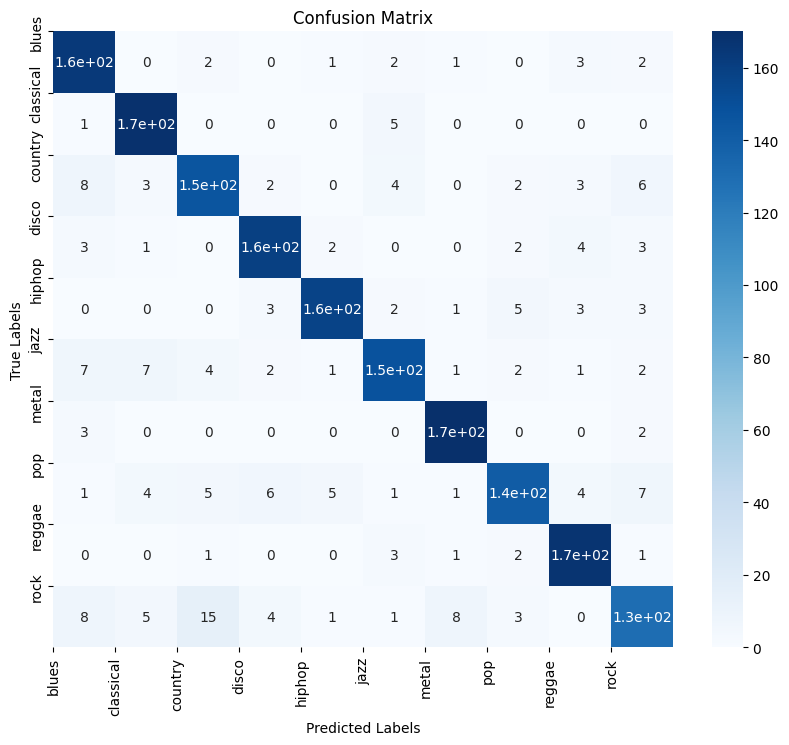

In [ ]:
# Load the saved model
# model = tf.keras.models.load_model('GRU_spectrogram_10sec_model.h5')
model_evaluation_report(model)

## lstm models

In [ ]:
# Build the CRNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

# Add recurrent layers (LSTM)
conv_output_shape = model.output_shape[1:]
model.add(layers.Reshape((conv_output_shape[1], conv_output_shape[0]*conv_output_shape[2])))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(32))

model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Define a ModelCheckpoint callback to save the entire model (including architecture and weights)
model_checkpoint = ModelCheckpoint('LSTM_spectrogram_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# # Train the model with early stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True  # Stop if val_loss doesn't improve for 5 epochs
)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_val, y_val), callbacks=[model_checkpoint])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1214 - loss: 2.2747
Epoch 1: val_accuracy improved from -inf to 0.21682, saving model to LSTM_spectrogram_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.1215 - loss: 2.2745 - val_accuracy: 0.2168 - val_loss: 2.0928
Epoch 2/200
202/203 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 2.0189
Epoch 2: val_accuracy improved from 0.21682 to 0.40847, saving model to LSTM_spectrogram_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2504 - loss: 2.0177 - val_accuracy: 0.4085 - val_loss: 1.5664
Epoch 3/200
202/203 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3926 - loss: 1.6268
Epoch 3: val_accuracy improved from 0.40847 to 0.47197, saving model to LSTM_spectrogram_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.3928 - loss: 1.6265 - val_accuracy: 0.4720 - val_loss: 1.4298
Epoch 4/200
202/203 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accurac

In [ ]:
from tensorflow.keras.models import load_model
# Load the best model
model = load_model('LSTM_spectrogram_model.keras')

# Evaluate the model's accuracy on train and test sets
train_acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1))
validate_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(model.predict(X_val), axis=1))
test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

# Print the accuracy scores
print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {validate_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

812/812 ━━━━━━━━━━━━━━━━━━━━ 67s 82ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
Train Accuracy: 95.31%
Validation Accuracy: 89.53%
Test Accuracy: 87.82%


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
              precision    recall  f1-score   support

       blues       0.94      0.85      0.89       175
   classical       0.88      0.98      0.93       175
     country       0.81      0.89      0.84       174
       disco       0.93      0.85      0.89       175
      hiphop       0.94      0.85      0.89       175
        jazz       0.91      0.81      0.85       175
       metal       0.91      0.95      0.93       175
         pop       0.81      0.83      0.82       175
      reggae       0.95      0.90      0.92       175
        rock       0.75      0.87      0.81       175

    accuracy                           0.88      1749
   macro avg       0.88      0.88      0.88      1749
weighted avg       0.88      0.88      0.88      1749



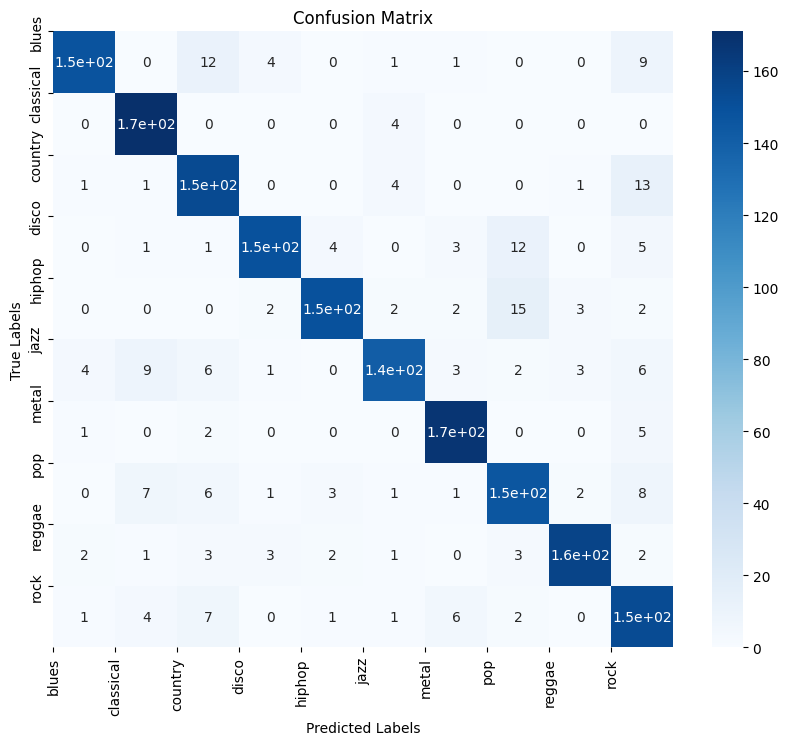

In [ ]:
# Load the saved model
model_evaluation_report(model)